<a href="https://colab.research.google.com/github/choltz95/density-estimation/blob/main/DS_manifold_with_boundary_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jaxopt

In [2]:
#@title imports
import jax
from jax import numpy as jnp
from jax import jit, grad, vmap
from jax.experimental.sparse import BCOO
from jax.config import config; config.update("jax_enable_x64", True)

from jaxopt import GaussNewton, NonlinearCG

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import sparse, spatial
from scipy.spatial.distance import pdist, squareform

from tqdm.notebook import tqdm

<ipython-input-2-032cb1adf043>:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [3]:
def sinkhorn(K, maxiter=100, delta=1e-10, eps=1e-8):
    """https://epubs.siam.org/doi/pdf/10.1137/20M1342124 """
    D = np.array(np.sum(K,0)).squeeze()
    d0 = 1./(D + eps)
    dp = 1./(K@d0 + eps)
    d = 1./(K@dp + eps)
    tau = 2
    for tau in tqdm(range(maxiter)):
        d = 1. / (K.T@dp + eps)
        dr = np.sqrt(dp * d)
        if np.max(np.abs(dp / d - 1)) < delta:
          break
        dp = d
    K = scipy.sparse.diags(dr) @ K @ scipy.sparse.diags(dr)
    return K, d

def __weights__(dists,h,m=2):
    """ Gaussian kernel: pi^{-m/2} exp(-||z||^2) """
    weights = (np.pi**(-m/2))*np.exp(-np.square(dists/h))
    fzero = 1
    return weights, fzero

def epsilon_ball(data, h, epsilon, epsilon_f=1, eta=None):
    """Construct a sparsified KDE (an epsilon-ball graph) """
    n = data.shape[0]  #Number of points

    #Rangesearch to find nearest neighbors
    Xtree = spatial.cKDTree(data)
    M = Xtree.query_pairs(epsilon)
    M = np.array(list(M))

    #Differences between points and neighbors
    V = data[M[:,0],:] - data[M[:,1],:]
    dists = np.sqrt(np.sum(V*V,axis=1))
    weights = __weights__(dists,h)

    # return K(||Xi - Xj|| / h)
    weights = np.concatenate((weights,weights))

    M1 = np.concatenate((M[:,0],M[:,1]))
    M2 = np.concatenate((M[:,1],M[:,0]))

    #Construct sparse matrix and convert to Compressed Sparse Row (CSR) format
    W = sparse.coo_matrix((weights, (M1,M2)),shape=(n,n))

    return W.tocsr()

def K1(X, h, m):
  return np.pi**(-m/2)*np.exp(-squareform(np.square(pdist(X)/h)))

def K2(X, K1, h, m):
  K2coef = X[:, None] - X[None, :]
  K2 = np.expand_dims(K1,-1)*K2coef
  return K2

def fn(N,h, m, K1):
  return 1/(N*h**m)*np.array(K1.sum(1,keepdims=True))

def mun(N, h, m, K2):
  o = jnp.ones(N)
  mun = o@K2
  mun = 1/(N*h**(m+1))*mun
  return mun

def c(fn, mun):
  return fn / (jnp.sqrt(jnp.pi) * jnp.linalg.norm(mun,axis=1,keepdims=True))

"""optimization of bx using gauss-newton on the residual """
@jit
def F(bx, h, c):
  return (1 + jax.lax.erf(bx / h))*jnp.exp((bx*bx) / (h*h)) - c

def bx(h, c):
  x_init = h * np.sqrt(np.maximum(0,np.log(c/2)))
  gn = GaussNewton(residual_fun=F, maxiter=1000, tol=1e-9, verbose=False)
  gn_sol = gn.run(x_init, h=h, c=c).params
  return gn_sol

def estimate_bx(N,h,m,K, X):
    _fn = fn(N,h, m, K)
    _K2 = K2(X, K, h, m)
    _mun = mun(N, h, m, _K2)
    _c = c(_fn, _mun)
    _bx = bx(h, _c)
    return _bx

In [5]:
mses_normal = []
mses_bistoch = []

for noise_level in [0.0, 0.01, 0.02, 0.05, 0.1]:
  mses_normal.append([])
  mses_bistoch.append([])
  for _ in tqdm(range(10)):
    N = 10000
    m = 2
    h = 0.2
    length = np.sqrt(np.random.uniform(0, 1, N))
    angle = np.pi * np.random.uniform(0, 2, N)

    sparse = False

    x = length * np.cos(angle)
    y = length * np.sin(angle)

    X_noiseless = np.stack([x,y],1)
    l = 1.0 - np.linalg.norm(X_noiseless, axis=1)

    X = np.stack([x,y, np.random.normal(loc=0,scale=noise_level,size=(N,))],1)

    _K1 = K1(X, h, m)
    _bx = estimate_bx(N,h,m,_K1,X)
    mses_normal[-1].append(1/l.shape[0] * np.linalg.norm(l- _bx.squeeze())**2)

    _K1 = sinkhorn(_K1)[0]
    _bx = estimate_bx(N,h,m,_K1,X)
    mses_bistoch[-1].append(1/l.shape[0] * np.linalg.norm(l- _bx.squeeze())**2)
  print(noise_level, 'std', np.mean(mses_normal[-1]), 'bistoch', np.mean(mses_bistoch[-1]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.0 std 0.03506411040829082 bistoch 0.031814854587097124


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.01 std 0.04782069043757585 bistoch 0.04621606767518377


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.02 std 0.05824249097067352 bistoch 0.05717491304184712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.05 std 0.08223058095181386 bistoch 0.0807907902093281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.1 std 0.10325062737301331 bistoch 0.09509648759559089


In [6]:
mses_bistoch

[[0.030341673869273087,
  0.03335489321307408,
  0.027643288301605232,
  0.032374716637457064,
  0.03272139081700018,
  0.0321421404455384,
  0.031912003289322956,
  0.033242793905553326,
  0.03383363939620621,
  0.030582005995940742],
 [0.045121141390216446,
  0.04806755597555944,
  0.04508998941993117,
  0.04737500920050417,
  0.045818336582038766,
  0.047450310351359506,
  0.04603063403329856,
  0.044639627694774725,
  0.045322720696136735,
  0.04724535140801816],
 [0.0586108465867526,
  0.05515418876916538,
  0.057832919925239736,
  0.056754868689175626,
  0.056295805782458956,
  0.05707554327784626,
  0.05806895543841769,
  0.0572467021887173,
  0.05747410815461299,
  0.057235191606084736],
 [0.08208785566041221,
  0.0804975443715039,
  0.07992394294818475,
  0.08010407927142635,
  0.08125399970029676,
  0.08165629668966717,
  0.07971872413374968,
  0.0814306635522852,
  0.08070586523603737,
  0.08052893052971753],
 [0.09659469438437834,
  0.094413156403556,
  0.09613921226220046,

In [7]:
mses_normal

[[0.03302524144489983,
  0.038014339776732416,
  0.029993541396405535,
  0.03609303474092459,
  0.03584248318539478,
  0.03448992436721163,
  0.03490298174310536,
  0.036728655625982896,
  0.037156726662916306,
  0.03439417513933487],
 [0.04614779469505068,
  0.05057176930598711,
  0.046744756329638676,
  0.04924009609995974,
  0.04707599082486895,
  0.04947590241399061,
  0.047845608759567844,
  0.045412590494350785,
  0.0466364893656952,
  0.049055906086648886],
 [0.060136838746464326,
  0.05594522140384252,
  0.05905616693363012,
  0.057930624506520124,
  0.05688910089541721,
  0.05820942931800523,
  0.05949796685208219,
  0.05827810613378122,
  0.05832975040264741,
  0.05815170451434481],
 [0.08379076663369293,
  0.08192766166342022,
  0.08127775926551639,
  0.08140887063030752,
  0.0827725866210386,
  0.0830614205384828,
  0.08118709321108979,
  0.0828137998588857,
  0.082167665029028,
  0.08189818606667656],
 [0.10496862729068011,
  0.10244901563538301,
  0.10455062873425004,
  0

Text(0, 0.5, 'MSE b/w est. bx and true distance')

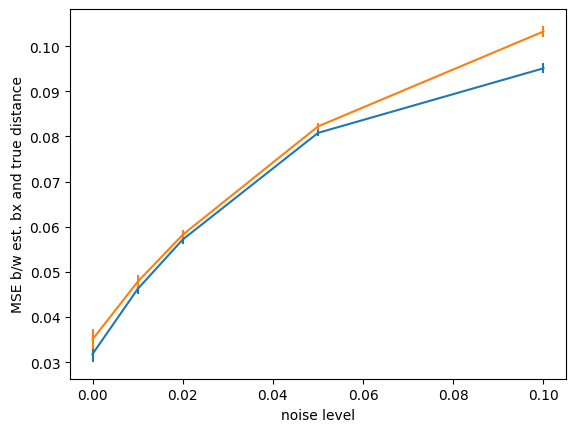

In [11]:
import matplotlib.pyplot as plt

bistoch_mse = [[0.030341673869273087,0.03335489321307408,0.027643288301605232,0.032374716637457064,0.03272139081700018,0.0321421404455384,0.031912003289322956,0.033242793905553326,0.03383363939620621,0.030582005995940742],[0.045121141390216446,0.04806755597555944,0.04508998941993117,0.04737500920050417,0.045818336582038766,0.047450310351359506,0.04603063403329856,0.044639627694774725,0.045322720696136735,0.04724535140801816],[0.0586108465867526,0.05515418876916538,0.057832919925239736,0.056754868689175626,0.056295805782458956,0.05707554327784626,0.05806895543841769,0.0572467021887173,0.05747410815461299,0.057235191606084736],[0.08208785566041221,0.0804975443715039,0.07992394294818475,0.08010407927142635,0.08125399970029676,0.08165629668966717,0.07971872413374968,0.0814306635522852,0.08070586523603737,0.08052893052971753],[0.09659469438437834,0.094413156403556,0.09613921226220046,0.09534485790117518,0.09575711543720088,0.09626243967030383,0.09541519553634932,0.09297905666642237,0.09357398122416588,0.0944851664701566]]
normal_mse = [[0.03302524144489983,0.038014339776732416,0.029993541396405535,0.03609303474092459,0.03584248318539478,0.03448992436721163,0.03490298174310536,0.036728655625982896,0.037156726662916306,0.03439417513933487],[0.04614779469505068,0.05057176930598711,0.046744756329638676,0.04924009609995974,0.04707599082486895,0.04947590241399061,0.047845608759567844,0.045412590494350785,0.0466364893656952,0.049055906086648886],[0.060136838746464326,0.05594522140384252,0.05905616693363012,0.057930624506520124,0.05688910089541721,0.05820942931800523,0.05949796685208219,0.05827810613378122,0.05832975040264741,0.05815170451434481],[0.08379076663369293,0.08192766166342022,0.08127775926551639,0.08140887063030752,0.0827725866210386,0.0830614205384828,0.08118709321108979,0.0828137998588857,0.082167665029028,0.08189818606667656],[0.10496862729068011,0.10244901563538301,0.10455062873425004,0.10338470170161713,0.10410933593212833,0.10393878840869489,0.10354624908752326,0.10096861673415154,0.10141379075675704,0.10317651944894787]]
bmsem = np.array(bistoch_mse).mean(1)
bmses = np.array(bistoch_mse).std(1)
nmsem = np.array(normal_mse).mean(1)
nmses = np.array(normal_mse).std(1)

noise_level = [0.0, 0.01, 0.02, 0.05, 0.1]

plt.errorbar(noise_level, bmsem, bmses, label='bistochastic scaling')
plt.errorbar(noise_level, nmsem, nmses, label='baseline (no scaling)')
plt.xlabel('noise level')
plt.ylabel('MSE b/w est. bx and true distance')
